# Team Turing
* Rishikesh Sivakumar
* Shreyan Yoge
* Sonali Bedade
* Tejaswi Chaudhari


# Trash Overflow
an automated technology to detect if government trash cans are overflowing with garbage or not and to intimate the person in authority if it is overflowing.

### Importing necessary modules

In [ ]:
from tqdm import tqdm
import os
import cv2
import numpy as np
import random as rn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D
import pickle as pkl

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

### Providing the paths of the dataset

In [ ]:
train_clean = '/content/drive/MyDrive/clean-dirty-garbage-containers/train/clean'
train_dirty = '/content/drive/MyDrive/clean-dirty-garbage-containers/train/dirty'
test_clean = '/content/drive/MyDrive/clean-dirty-garbage-containers/test/clean'
test_dirty = '/content/drive/MyDrive/clean-dirty-garbage-containers/test/dirty'

In [ ]:
def categories(img, dustbin_data):
  return dustbin_data

In [ ]:
X = []
y = []
X_val = []
y_val = []
IMG_SIZE = 150

### Functions to generate train and test data

In [ ]:

def make_train_data(dustbin_data, location):
  for img in tqdm(os.listdir(location)):
    label=categories(img,dustbin_data)
    path = os.path.join(location,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

    X.append(np.array(img))
    y.append(str(label))

In [ ]:
def make_test_data(dustbin_data, location):
  for img in tqdm(os.listdir(location)):
    label=categories(img,dustbin_data)
    path = os.path.join(location,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

    X_val.append(np.array(img))
    y_val.append(str(label))

In [ ]:
make_train_data('Clean',train_clean)
print(len(X))

100%|██████████| 1206/1206 [00:31<00:00, 38.45it/s]

1206


In [ ]:
make_train_data('Dirty',train_dirty)
print(len(X))

100%|██████████| 1011/1011 [00:36<00:00, 27.40it/s] 

2217


### Data Visualization

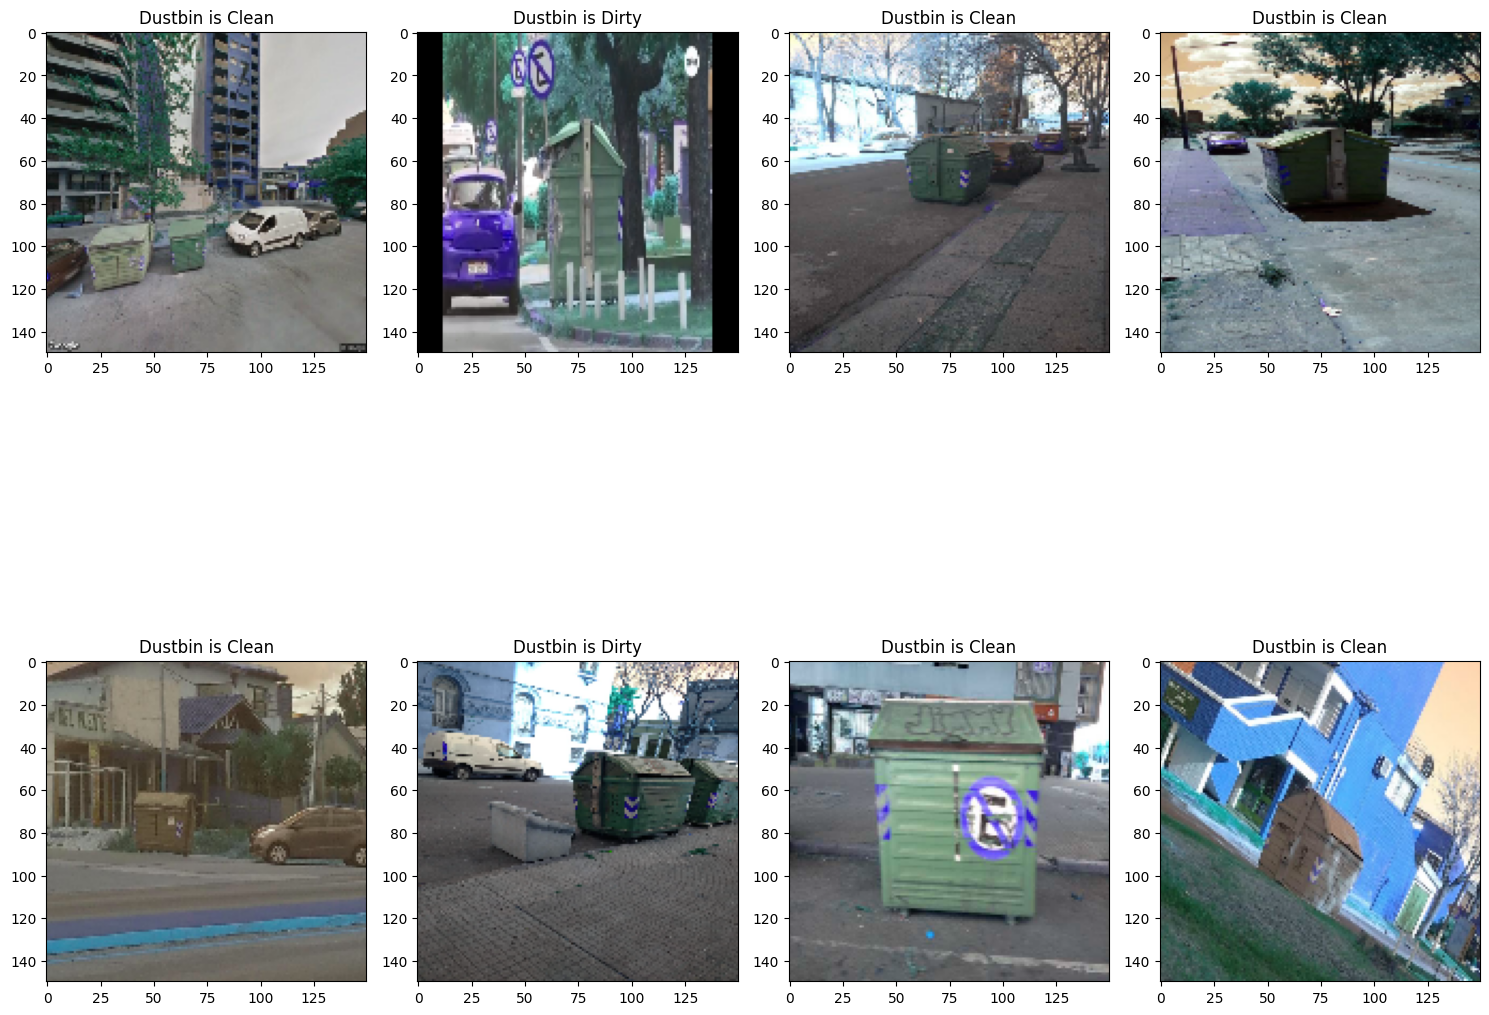

In [ ]:
fig,ax=plt.subplots(2,4)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range (4):
        m=rn.randint(0,len(y))
        ax[i,j].imshow(X[m])
        ax[i,j].set_title('Dustbin is '+y[m])

plt.tight_layout()

In [ ]:
le=LabelEncoder()
y_label=le.fit_transform(y)
y_label=to_categorical(y_label,2)
X=np.array(X)
X=X/255

In [ ]:
X.shape

(2217, 150, 150, 3)

In [ ]:
y_label.shape

(2217, 2)

In [ ]:
make_test_data('Clean',test_clean)
print(len(X_val))

100%|██████████| 600/600 [00:18<00:00, 32.74it/s]

600


In [ ]:
make_test_data('Dirty',test_dirty)
print(len(X_val))

100%|██████████| 595/595 [00:35<00:00, 16.55it/s]

1195


In [ ]:
y_test_label=le.fit_transform(y_val)
y_test_label=to_categorical(y_test_label,2)
X_val=np.array(X_val)
X_val=X_val/255

In [ ]:
X_val.shape

(1195, 150, 150, 3)

In [ ]:
y_test_label.shape

(1195, 2)

In [ ]:
np.random.seed(40)
rn.seed(40)
tf.random.set_seed(40)

### Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        zoom_range = 0.1,
        width_shift_range=0.2,
        height_shift_range=0.2
        )


datagen.fit(X)

In [ ]:
X.shape

(2217, 150, 150, 3)

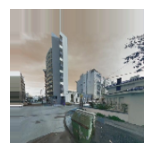

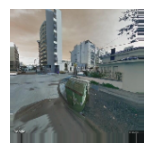

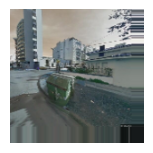

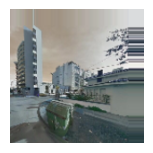

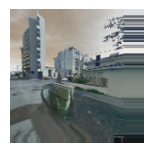

In [ ]:
gen = datagen.flow(X[1:2], batch_size=1)
for i in range(1, 6):
  plt.figure(figsize=(10,10))
  plt.subplot(1,5,i)
  plt.axis("off")
  plt.imshow(gen.next().squeeze())
  plt.plot()
plt.show()

### CNN Model

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation = "softmax"))

In [ ]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau  # Reduce learning rate when a metric has stopped improving.
reduce_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [ ]:
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 37, 37, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 18, 18, 96)       

In [ ]:
X.shape

(2217, 150, 150, 3)

In [ ]:
pickled_model = pkl.load(open('model_best.pkl', 'rb'))

### Interative GUI for demo

In [ ]:
def model_predict(img):
  img = img.reshape(-1,150,150,3)
  predictions = pickled_model.predict(img)[0]
  labels = ['Clean', 'Dirty']
  return {labels[i]: float(predictions[i]) for i in range(2)}

In [ ]:
interface = gr.Interface(fn = model_predict,
                         inputs = gr.inputs.Image(shape=(150,150)),
                         outputs = gr.outputs.Label(num_top_classes=2),
                         title = 'Trash Overflow',
                         )

<ipython-input-188-913b26c66e0e>:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs = gr.inputs.Image(shape=(150,150)),
<ipython-input-188-913b26c66e0e>:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs = gr.inputs.Image(shape=(150,150)),
<ipython-input-188-913b26c66e0e>:3: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs = gr.outputs.Label(num_top_classes=2),
<ipython-input-188-913b26c66e0e>:3: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  outputs = gr.outputs.Label(num_top_classes=2),


In [ ]:
interface.launch(share = True, debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://fe2972cbd0bfd08af4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 36ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/routes.py", line 508, in predict
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 219, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1437, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1109, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    result = con

1/1 [==============================] - 0s 60ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/routes.py", line 508, in predict
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 219, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1437, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1109, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    result = con

1/1 [==============================] - 0s 56ms/step
